In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip
import seaborn as sns

% matplotlib inline
%load_ext autoreload
% autoreload

In [2]:
cd /data

/data


In [3]:
data_naspm = pd.read_pickle('ana_naspm')

In [4]:
data_naspm

,Before,After,elimi
2017091202,"{'onset_tau': 0.735, 'rs': [[23.0605624864], [...","{'onset_tau': 0.908571428571, 'rs': [[25.01115...",25
2017091301,"{'onset_tau': 0.56, 'rs': [[32.3563232612], [3...","{'onset_tau': 0.544, 'rs': [[38.6134763716], [...",30
2017092702,"{'onset_tau': 0.648, 'rs': [[25.1589494553], [...","{'onset_tau': 0.821333333333, 'rs': [[25.88989...",20
2017092901,"{'onset_tau': 0.818181818182, 'rs': [[26.80235...","{'onset_tau': 0.756571428571, 'rs': [[26.89678...",40
2017102501,"{'onset_tau': 0.618, 'rs': [[26.8895608564], [...","{'onset_tau': 0.60625, 'rs': [[34.1354933282],...",40


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<Container object of 3 artists>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


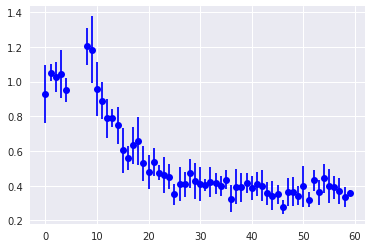

In [40]:
data = data_naspm
ave_ptl_resp = np.ones((len(data), 60))*np.nan

for i in range(len(data)):
    bef_resp = data.iloc[i]['Before']['ave_amp1'][-5:]
    bef_rs = np.nanmean(data.iloc[i]['Before']['rs'][-5:])
    aft_rs = np.nanmean(data.iloc[i]['After']['rs'][:(data.iloc[i]['elimi']-7)][-5:])
    aft_resp = data.iloc[i]['After']['ave_amp1'][:(data.iloc[i]['elimi']-7)]*aft_rs/bef_rs
    bef_mean = np.nanmean(bef_resp)
    if aft_resp.shape[0] < 52:
        length_fill = 52 - aft_resp.shape[0]
        mean_fill = np.nanmean(aft_resp[-5:])
        ste_fill =  np.nanstd(aft_resp[-5:])
        np.random.seed(i)
        aft_fill = np.random.normal(loc=mean_fill, scale=ste_fill, size=(1,length_fill))  
        aft_resp = np.concatenate((aft_resp, aft_fill.reshape(-1,1)))
    
    bef_resp = bef_resp/bef_mean
    aft_resp = aft_resp/bef_mean
    resp1_joint= np.concatenate([bef_resp, np.ones((3,1))*np.nan, aft_resp])
    ave_ptl_resp[i,:5] = bef_resp.reshape(1,-1)
    ave_ptl_resp[i,8:] = aft_resp[-52:].reshape(1,-1)
#   plt.figure()
#   plt.plot(resp1_joint, 'o', label='Resp 1')

ave_ptl_mean_2 = np.nanmean(ave_ptl_resp, axis=0)
ave_ptl_ste_2 = np.nanstd(ave_ptl_resp, axis=0)/np.sqrt(i)
plt.errorbar(x=np.arange(len(ave_ptl_mean_2)), y=ave_ptl_mean_2, yerr=ave_ptl_ste_2, fmt='bo')


In [41]:
# Perform processing on before amplitude
def pro_bef(data_mean, data_ste, scale=0.1):
    for i in range(len(data_mean)):
        if data_mean[i]+data_ste[i]<1:
            data_mean[i] = 1 - scale*data_ste[i]
        elif data_mean[i]-data_ste[i]>1:
            data_mean[i] = 1 + scale*data_ste[i]
            
    return data_mean, data_ste

In [42]:
ave_ptl_mean_2cp, ave_ptl_ste_2cp =  ave_ptl_mean_2, ave_ptl_ste_2
ave_ptl_mean, ave_ptl_ste = pro_bef(ave_ptl_mean_2cp[:5], ave_ptl_ste_2cp[:5])
ave_ptl_mean_2cp[:5], ave_ptl_ste_2cp[:5] = ave_ptl_mean, ave_ptl_ste 
ave_ptl_mean, ave_ptl_ste = pro_bef(ave_ptl_mean_2cp[8:12], ave_ptl_ste_2cp[8:12]/1.5, scale=0.5)
ave_ptl_mean_2cp[8:12], ave_ptl_ste_2cp[8:12] = ave_ptl_mean, ave_ptl_ste
ave_ptl_mean_2cp[5:57], ave_ptl_ste_2cp[5:57] = ave_ptl_mean_2cp[8:60], ave_ptl_ste_2cp[8:60]

[0, 60, 0.1, 1.7]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


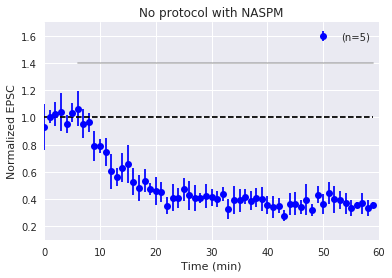

In [52]:
plt.errorbar(x=np.arange(len(ave_ptl_mean_2cp)), y=ave_ptl_mean_2cp, yerr=ave_ptl_ste_2cp, fmt='bo', label='(n={a})'.format(a=len(data)))
plt.plot(np.arange(6,60), np.ones((len(np.arange(6,60)))) * 1.4, 'grey', alpha=0.5)
plt.plot(np.ones((60))*1, 'k--')
plt.xlabel('Time (min)')
plt.ylabel('Normalized EPSC')
plt.legend()
plt.title('No protocol with NASPM')
plt.axis([0,60,0.1,1.7])